# 1. Preemptive Research

The Oxford Flowers102 dataset is a popular dataset on Kaggle and based off this leaderboard, https://paperswithcode.com/sota/image-classification-on-flowers-102, the best classification accuracy achieved is 99.76% by a CvT-W24 neural network trained with extra data. Without extra data, the best network was a TransBoost-ResNet50 model with 97.85% accuracy. This notebook attempts to recreate the TransBoost-Resnet50 model by using acquiring a pretrained ResNet50 model from Pytorch trained on ImageNet and performing transfer learning on it by training it on the Flowers102 dataset.    

# 2. Training and saving the model

## Import Pytorch and other dependencies

In [1]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import Flowers102
from torchvision.transforms import transforms
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models


import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import time
import seaborn as sns

import torch.nn as nn
import torch.optim as optim

from PIL import Image

In [2]:
# set to GPU if its available

device = torch.device('cpu')
if torch.cuda.is_available():
    print(f'Found {torch.cuda.device_count()} GPU(s).')
    device = torch.device('cuda:0')
print(f'The device is set to {device}')


Found 1 GPU(s).
The device is set to cuda:0


## Load model and image dataset

In [3]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [4]:
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize]),

    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),

    'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize
    ])
}

training_set = datasets.ImageFolder('data2/train', transform=data_transforms['train'])
validation_set = datasets.ImageFolder('data2/valid', transform=data_transforms['validation'])
test_set = datasets.ImageFolder('data2/test', transform=data_transforms['test'])

print(np.max(training_set.targets))
idx_to_class = { v:k for k,v in training_set.class_to_idx.items()}

# make sure training labels are the same as testing labels to ensure that testing works
assert training_set.class_to_idx == test_set.class_to_idx

# Pytorch's Image folder creates an internal representation of folder names to actual numbered labels 
# So we have to create another map to convert Pytorch label's to folder names and then convert those to actual flower names
print(idx_to_class)



# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=0)

dataloaders = {'train': training_loader, 'val': validation_loader}
dataset_sizes = {'train': len(training_set), 'val': len(validation_set)}

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))
print('Test set has {} instances'.format(len(test_set)))

101
{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 

### Sanity Check (Display images)

tensor([82,  2, 86, 96, 49, 33, 77, 39])


<AxesSubplot: title={'center': "['frangipani', 'blanket flower', 'desert-rose', 'foxglove', 'petunia', 'cape flower', 'passion flower', 'daffodil']"}>

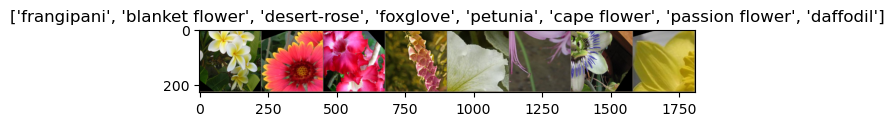

In [5]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.permute(1, 2, 0)
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image.numpy() + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# from https://github.com/bdevnani3/oxfordflowers102-label-name-mapping/blob/main/mapping.json
with open('udacity_label_to_name.json', 'r') as f:
    flower_to_name = json.load(f)

dataiter = iter(training_loader)
images, labels = next(dataiter)
print(labels[0:8])

# Create a grid from the images and show them
out = torchvision.utils.make_grid(images[0:8])
imshow(out, title=[flower_to_name[idx_to_class[labels[j].item()]] for j in range(8)])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
# modifying architecture for transfer learning
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(flower_to_name))
model_ft = model.to(device)
epochs = 9
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [8]:
# train model using transfer learning
model_tl = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)

Epoch 0/8
----------
train Loss: -328.4895 Acc: 0.0371
val Loss: -691.7131 Acc: 0.0440

Epoch 1/8
----------
train Loss: -1588.1715 Acc: 0.0487
val Loss: -3615.8274 Acc: 0.0452

Epoch 2/8
----------
train Loss: -2878.6009 Acc: 0.0525
val Loss: -2905.9665 Acc: 0.0465

Epoch 3/8
----------
train Loss: -3162.9940 Acc: 0.0534
val Loss: -3515.9137 Acc: 0.0465

Epoch 4/8
----------
train Loss: -3293.4557 Acc: 0.0536
val Loss: -3001.0086 Acc: 0.0465

Epoch 5/8
----------
train Loss: -3302.2809 Acc: 0.0524
val Loss: -3404.8520 Acc: 0.0465

Epoch 6/8
----------
train Loss: -3322.6986 Acc: 0.0533
val Loss: -3192.3708 Acc: 0.0465

Epoch 7/8
----------
train Loss: -3322.1788 Acc: 0.0533
val Loss: -3184.1291 Acc: 0.0465

Epoch 8/8
----------
train Loss: -3332.7096 Acc: 0.0536
val Loss: -2787.3633 Acc: 0.0465

Training complete in 55m 45s
Best val Acc: 0.046455


### Saving and Reloading the model

In [9]:
model_tl.cpu()
torch.save({'arch': 'resNet50',
            'state_dict': model_tl.state_dict(), 
            'class_to_idx': training_set.class_to_idx}, 
            'resNet50classifierHigherAcc.pth')

In [10]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'resNet50':
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
        exit()
    
    model.class_to_idx = chpt['class_to_idx']
    num_ftrs = model.fc.in_features

    model.fc = nn.Linear(num_ftrs, len(flower_to_name))

    model.load_state_dict(chpt['state_dict'])
    model.to(device) 
    return model

In [11]:
model_tl = load_model('resNet50classifier.pth')

# 3. Testing Model

In [12]:
running_accuracy = 0 
total = 0 
with torch.no_grad(): 
	for data in test_loader: 
		inputs, outputs = data
		inputs = inputs.to(device)
		outputs = outputs.to(device)
		outputs = outputs.to(torch.float32) 

		predicted_outputs = model_tl(inputs) 
		_, predicted = torch.max(predicted_outputs, 1) 
		total += outputs.size(0) 
		running_accuracy += (predicted == outputs).sum().item() 

print('Accuracy of the model based on the test set of 819 inputs is: %d %%' % (100 * running_accuracy / total))    

Accuracy of the model based on the test set of 819 inputs is: 38 %


### Perform transforms that were used in training/validation

In [13]:
def process_image(image_path):
    img = Image.open(image_path)
    adjust = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    img_tensor = adjust(img)
    return img_tensor

## Sanity Checking

Determining if the model finds the right label with high probability based on a hand-picked test set (smoke-testing)

In [14]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    processed_image = process_image(image_path)
    processed_image.unsqueeze_(0)
    processed_image = processed_image.to(device)
    probs = torch.exp(model.forward(processed_image))
    top_probs, top_labs = probs.topk(topk)

    top_probs = top_probs.cpu()
    top_labs = top_labs.cpu()

    idx_to_class = {}
    for key, value in model.class_to_idx.items():
        idx_to_class[value] = key

    np_top_labs = top_labs[0].numpy()

    top_labels = []
    for label in np_top_labs:
        top_labels.append(int(idx_to_class[label]))

    top_flowers = [flower_to_name[idx_to_class[lab]] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

In [15]:
predict("./data2/test/1/image_06743.jpg", model_tl)

(tensor([[5.0542, 3.5680, 3.5285, 3.2932, 3.1703]], grad_fn=<ToCopyBackward0>),
 [53, 84, 83, 65, 91],
 ['pelargonium', 'hibiscus', 'clematis', 'osteospermum', 'monkshood'])

In [18]:
def plot_solution(image_path, model):
    # Sets up our plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = flower_to_name[flower_num] # Calls dictionary for name
    # Plot flower
    img = process_image(image_path)
    plt.title("Actual Label: " + title_)
    imshow(img, ax)
    # Make prediction
    top_probs, top_labels, top_flowers = predict(image_path, model) 
    top_probs = top_probs[0].detach().numpy() #converts from tensor to nparray
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=top_probs, y=top_flowers, color=sns.color_palette()[0])
    plt.show()

    print(top_probs, top_labels, top_flowers)

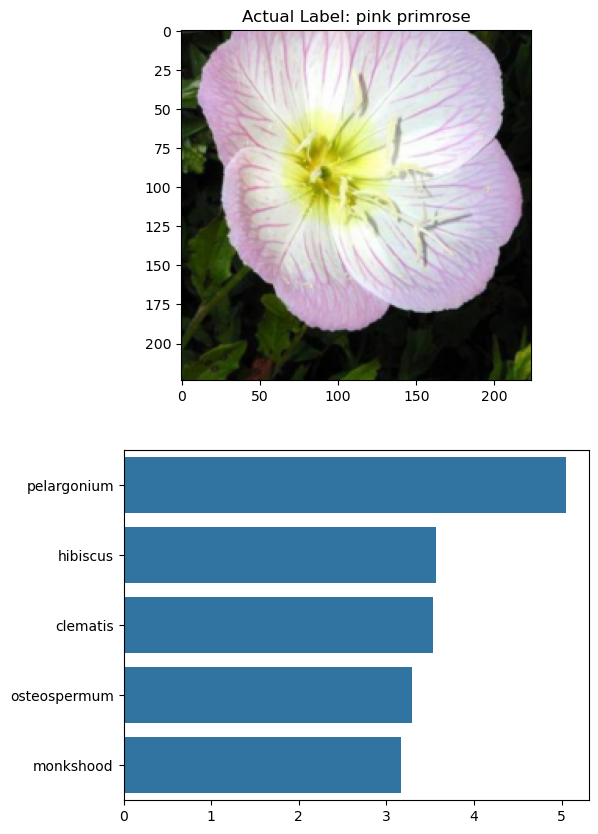

[5.05418   3.56795   3.5284772 3.2932496 3.1702902] [53, 84, 83, 65, 91] ['pelargonium', 'hibiscus', 'clematis', 'osteospermum', 'monkshood']


In [19]:
plot_solution("data2/test/1/image_06743.jpg", model_tl)

In [ ]:
def visualize_model(model, num_images=6):
    model.to(device)
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {flower_to_name[idx_to_class[preds[j].item()]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_tl)